In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Concatenate,Input,Resizing
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau ,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
# Define dataset directories
train_dir = "Teeth_DataSet/Teeth_Dataset/Training"
val_dir = "Teeth_DataSet/Teeth_Dataset/Validation"
test_dir = "Teeth_DataSet/Teeth_Dataset/Testing"

IMG_SIZE = 224  # Required for InceptionResNetV2
BATCH_SIZE = 32  # You can adjust batch size


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# List all class folders in the directories
all_train_classes = os.listdir(train_dir)
all_val_classes = os.listdir(val_dir)
all_test_classes = os.listdir(test_dir)

# Define classes to exclude
excluded_classes = ["out", "output", "outputs", "output_image.jpg"]  

# Filter out unwanted classes
selected_train_classes = [cls for cls in all_train_classes if cls not in excluded_classes]
selected_val_classes = [cls for cls in all_val_classes if cls not in excluded_classes]
selected_test_classes = [cls for cls in all_test_classes if cls not in excluded_classes]

# Load Training Data (excluding unwanted classes)
train_data = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(IMG_SIZE, IMG_SIZE),  # FIX: Ensure it's a tuple
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=selected_train_classes  
)

# Load Validation Data (excluding unwanted classes)
val_data = val_datagen.flow_from_directory(
    val_dir, 
    target_size=(IMG_SIZE, IMG_SIZE),  # FIX: Ensure it's a tuple
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=selected_val_classes
)

# Load Test Data (excluding unwanted classes)
test_data = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(IMG_SIZE, IMG_SIZE),  # FIX: Ensure it's a tuple
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=selected_test_classes
)

# Class Names
class_names = list(train_data.class_indices.keys())
print("Loaded Classes:", class_names)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Loaded Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


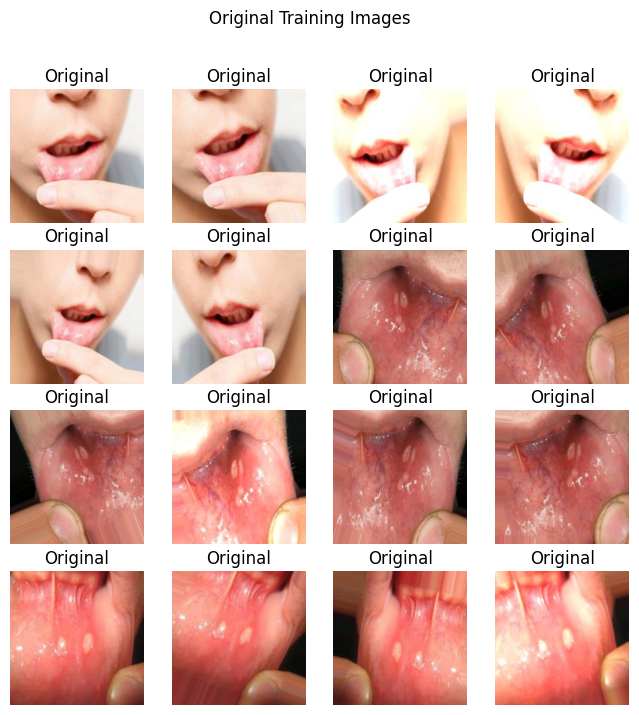

In [7]:
# # Display original images
# def display_original_images(dataset, title):
#     fig, axes = plt.subplots(4, 4, figsize=(8, 8))
#     axes = axes.ravel()
    
#     for i in range(16):
#         img_path = dataset.filepaths[i]
#         original_img = cv2.imread(img_path)
#         original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#         original_img = cv2.resize(original_img, IMG_SIZE)
        
#         axes[i].imshow(original_img)
#         axes[i].set_title("Original")
#         axes[i].axis('off')
    
#     plt.suptitle(title)
#     plt.show()

# display_original_images(train_data, "Original Training Images")
def display_original_images(dataset, title):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.ravel()
    
    for i in range(16):
        img_path = dataset.filepaths[i]
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))  # Fix: Convert to tuple
        
        axes[i].imshow(original_img)
        axes[i].set_title("Original")
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.show()
display_original_images(train_data, "Original Training Images")


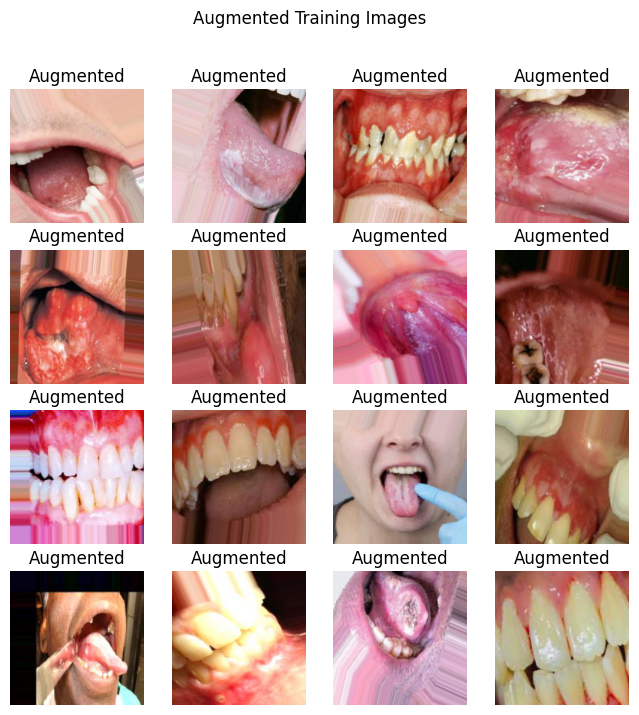

In [8]:
# Display augmented images
def display_augmented_images(dataset, title):
    images, labels = next(dataset)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.ravel()
    
    for i in range(16):
        axes[i].imshow(images[i])
        axes[i].set_title("Augmented")
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.show()

display_augmented_images(train_data, "Augmented Training Images")

In [9]:
# Get class names
class_names = list(train_data.class_indices.keys())
NUM_CLASSES = len(class_names)

In [10]:
# Load Pre-trained InceptionResNetV2 (Transfer Learning)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

In [11]:
# Build model
input_layer = Input(shape=(224, 224, 3))
feature_extraction = base_model(input_layer, training=False)
global_avg_pooling = GlobalAveragePooling2D()(feature_extraction)
dense1 = Dense(128, activation='relu')(global_avg_pooling)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(NUM_CLASSES, activation='softmax')(dropout)
model = Model(inputs=input_layer, outputs=output_layer)

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')

In [14]:
# Train the Model
history = model.fit(
    train_data, validation_data=val_data, epochs=80, batch_size=4, callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/80


C:\Users\Dodooz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.1985 - loss: 2.2551 - val_accuracy: 0.4105 - val_loss: 1.5968
Epoch 2/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.3592 - loss: 1.6684 - val_accuracy: 0.4591 - val_loss: 1.4561
Epoch 3/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4119 - loss: 1.5578 - val_accuracy: 0.5117 - val_loss: 1.3406
Epoch 4/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.4410 - loss: 1.4646 - val_accuracy: 0.5535 - val_loss: 1.2770
Epoch 5/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.4707 - loss: 1.3840 - val_accuracy: 0.5963 - val_loss: 1.2115
Epoch 6/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5104 - loss: 1.3380 - val_accuracy: 0.5866 - val_loss: 1.1586
Epoch 7/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5377 - loss: 1.2918 - val_accuracy: 0.6099 - val_loss: 1.1277
Epoch 8/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5334 - loss: 1.2379 - val_accuracy: 0.6187 - val_loss: 1.

In [15]:
# Fine-tune the model
base_model.trainable = True  # Unfreeze last layers
for layer in base_model.layers[:-50]:  # Keep first layers frozen
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
# Fine-tune training
history_fine_tune = model.fit(
    train_data, validation_data=val_data, epochs=50, batch_size=4, callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7430 - loss: 0.7917 - val_accuracy: 0.8638 - val_loss: 0.4559
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7776 - loss: 0.6792 - val_accuracy: 0.8794 - val_loss: 0.4343
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7663 - loss: 0.6629 - val_accuracy: 0.8901 - val_loss: 0.4081
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8040 - loss: 0.5888 - val_accuracy: 0.9056 - val_loss: 0.3744
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8405 - loss: 0.5282 - val_accuracy: 0.9105 - val_loss: 0.3433
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8346 - loss: 0.5100 - val_accuracy: 0.9163 - val_loss: 0.3158
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8324 - loss: 0.5129 - val_accuracy: 0.9290 - val_loss: 0.2937
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8435 - loss: 0.4911 - val_accuracy: 0.9309 - v

In [19]:
# Save fine-tuned model
model.save("fine_tuned_model.keras")